# Overview

This notebook trained YOLOv7 to detect car plates and subsequently converted it to a TFLite to be deployable on mobile phones in the later stage of the product.

This investigation of the YOLO model is part of the exploratory phase. It will later be compared with other solutions in terms of accuracy, computation cost, deployability on mobile phone, etc.

# Summary
The notebook does the following:
- Download pre-trained YOLOv7 and train with the custom car plate data.
- Convert to ONXX model
- Convert to TF then TFLite
- Make predictions using TFLite

## Data
We have limited labelled dataset to train the model. In this project, [this public dataset](https://drive.google.com/drive/folders/1DghyfRyo3Rdl0lxBwkevsBjKIjJ_5NrX) was used to train the model. The train/test sets consist of 1500/300 images of car plates respectively.

## References
- https://medium.com/geekculture/journey-putting-yolo-v7-model-into-tensorflow-lite-object-detection-api-model-running-on-android-e3f746a02fc4
- https://medium.com/geekculture/converting-yolo-v7-to-tensorflow-lite-for-mobile-deployment-ebc1103e8d1e



# Setup environment

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
proj_dir = '/content/gdrive/My Drive/colab_notebooks/car_plate_detection_yolov7'

In [ ]:
%cd $proj_dir

!pip --quiet install onnx onnxruntime onnxsim onnx-tf coremltools tflite-runtime pyyaml

/content/gdrive/My Drive/colab_notebooks/car_plate_detection_yolov7
     |████████████████████████████████| 13.1 MB 15.6 MB/s 
     |████████████████████████████████| 4.9 MB 59.0 MB/s 
     |████████████████████████████████| 2.0 MB 50.0 MB/s 
     |████████████████████████████████| 226 kB 78.1 MB/s 
     |████████████████████████████████| 1.5 MB 63.7 MB/s 
     |████████████████████████████████| 2.5 MB 79.4 MB/s 
     |████████████████████████████████| 46 kB 4.4 MB/s 
     |████████████████████████████████| 237 kB 91.6 MB/s 
     |████████████████████████████████| 1.1 MB 47.5 MB/s 
     |████████████████████████████████| 86 kB 7.1 MB/s 
     |████████████████████████████████| 51 kB 6.6 MB/s 


In [ ]:
import os
import random
import time
import requests
import random
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple
import matplotlib.pyplot as plt
import cv2
import numpy as np
import onnxruntime as ort
import tensorflow as tf

## Downloading pre-trained models

In [ ]:
![[ ! -d "models" ]] &&  mkdir models
%cd models

/content/gdrive/MyDrive/colab_notebooks/car_plate_detection_yolov7/models


In [ ]:
![[ ! -d "yolov7" ]] && git clone https://github.com/WongKinYiu/yolov7.git
%cd yolov7
![[ ! -f "yolov7.pt" ]] && wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt
![[ ! -f "yolov7-tiny.pt" ]] && wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt

# back to top
%cd $proj_dir

/content/gdrive/MyDrive/colab_notebooks/car_plate_detection_yolov7/models/yolov7
/content/gdrive/My Drive/colab_notebooks/car_plate_detection_yolov7


# Train model with our custom data

In [ ]:
original_config_file = "models/yolov7/cfg/training/yolov7-tiny.yaml"

import yaml
from yaml.loader import SafeLoader

# Open the file and load the file
with open(original_config_file) as f:
    data = yaml.load(f, Loader=SafeLoader)
    data["train"] = os.path.join(proj_dir,'dataset/train/')
    data["val"] = os.path.join(proj_dir,'dataset/validation/')
    data["test"] = os.path.join(proj_dir,'dataset/test_raw/') # to be added later
    data["nc"] = 1 # Number of classes
    data["names"] = ["car_plate"]

    with open(os.path.join(proj_dir,"dataset/data.xml"), "w") as output_file:
       output_file.write(yaml.dump(data))

In [ ]:
!python models/yolov7/train.py --batch 16 --epochs 100 --data dataset/data.xml --weights 'models/yolov7/yolov7-tiny.pt' --device 0

# Convert and make inference

In [ ]:
# these constants are used across all following sections
#Name of the classes according to class indices.
NAMES = ['car_plate']

#Creating random colors for bounding box visualization.
COLORS = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(NAMES)}

# point to your own folder
test_path = 'dataset/test_raw'

In [ ]:
def load_image(file_name:str,test_path:str=test_path):
  img = cv2.imread(f"{test_path}/{file_name}")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  #Preprocessing the image for prediction.
  image = img.copy()
  image, ratio, dwdh = letterbox(image, auto=False)
  image = image.transpose((2, 0, 1))
  image = np.expand_dims(image, 0)
  image = np.ascontiguousarray(image)

  processed_img = image.astype(np.float32)
  processed_img /= 255

  return img, processed_img, ratio, dwdh

def letterbox(im, new_shape=(416, 416), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

def visualise_box(ori_images,dwdh,ratio,batch_id,x0,y0,x1,y1,cls_id,score):
    image = ori_images[int(batch_id)]
    box = np.array([x0,y0,x1,y1])
    box -= np.array(dwdh*2)
    box /= ratio
    box = box.round().astype(np.int32).tolist()
    cls_id = int(cls_id)
    score = round(float(score),3)
    name = NAMES[cls_id]
    color = COLORS[name]
    name += ' '+str(score)
    cv2.rectangle(image,box[:2],box[2:],color,2)
    cv2.putText(image,name,(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)

    return ori_images

## Converting the model to ONXX

Exporting the PyTorch model to the ONNX model using the export script created by the YOLO v7 developers

In [ ]:
!python models/yolov7/export.py --weights runs/train/exp/weights/best.pt --grid --end2end --simplify \
--topk-all 100 --iou-thres 0.65 --conf-thres 0.35 --img-size 416 416 --max-wh 416

### Making Inference Using the Onnx Model

Mainly to verify the model works as expected

In [ ]:
cuda = False
w = "runs/train/exp/weights/best.onnx"

providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if cuda else ['CPUExecutionProvider']
session = ort.InferenceSession(w, providers=providers)

In [ ]:
def make_inference_with_onnx(session,file_name:str,path:str=test_path):
  img, processed_img, ratio, dwdh = load_image(file_name,path)

  #Getting onnx graph input and output names.
  outname = [i.name for i in session.get_outputs()]
  inname = [i.name for i in session.get_inputs()]
  inp = {inname[0]:processed_img}

  # Running inference using session.
  start = time.time()
  outputs = session.run(outname, inp)[0]
  end = time.time()
  print(end-start)


  ori_images = [img.copy()]

  #Visualizing bounding box prediction.
  for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(outputs):
    ori_images = visualise_box(ori_images,dwdh,ratio,batch_id,x0,y0,x1,y1,cls_id,score)

  plt.imshow(ori_images[0])

  return outputs

0.03540992736816406


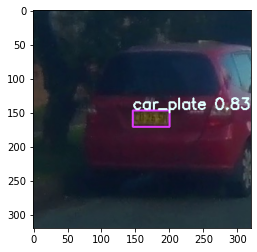

In [ ]:
#_ = make_inference_with_onnx(session,'vlcsnap-2022-09-05-14h57m40s824.jpg')
_ = make_inference_with_onnx(session,'vlcsnap-2022-09-05-14h57m44s482.jpg')
#_ = make_inference_with_onnx(session,'vlcsnap-2022-09-05-15h02m24s169.jpg')

## Converting the Onnx Model to TF then TFLite

In [ ]:
!onnx-tf convert -i "runs/train/exp/weights/best.onnx" -o saved_model_tiny

2022-10-06 10:45:58,013 - onnx-tf - INFO - Start converting onnx pb to tf saved model
INFO:onnx-tf:Start converting onnx pb to tf saved model
2022-10-06 10:45:58.762618: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-10-06 10:46:07.717101: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-10-06 10:46:10,438 - onnx-tf - INFO - Converting completes successfully.
INFO:onnx-tf:Converting completes successfully.


In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model('saved_model_tiny')

# IMPORTANT: adding this somehow makes it worse
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('yolov7_tiny_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
!du -sh yolov7_tiny_model.tflite

24M	yolov7_tiny_model.tflite


In [ ]:
# Futher quantizing the model to reduce its size and inference time
# when deployed on mobile phones
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model_tiny')

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

with open('yolov7_tiny_model_float16.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
!du -sh yolov7_tiny_model_float16.tflite

12M	yolov7_tiny_model_float16.tflite


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model_tiny')

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('yolov7_tiny_model_dynamic.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
!du -sh yolov7_tiny_model_dynamic.tflite

6.3M	yolov7_tiny_model_dynamic.tflite


## Making predictions using the TFlite model

In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="yolov7_tiny_model_float16.tflite")

def make_inference_with_tflite(interpreter,file_name:str,path:str=test_path):
  img, processed_img, ratio, dwdh = load_image(file_name,path)

  #Allocate tensors.
  interpreter.allocate_tensors()
  # Get input and output tensors.
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # Test the model on random input data.
  input_shape = input_details[0]['shape']
  interpreter.set_tensor(input_details[0]['index'], processed_img)

  start = time.time()
  interpreter.invoke()
  end = time.time()
  print(end - start)

  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  outputs = interpreter.get_tensor(output_details[0]['index'])

  ori_images = [img.copy()]

  #Visualizing bounding box prediction.
  for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(outputs):
    ori_images = visualise_box(ori_images,dwdh,ratio,batch_id,x0,y0,x1,y1,cls_id,score)

  plt.imshow(ori_images[0])

  return outputs

0.13976573944091797


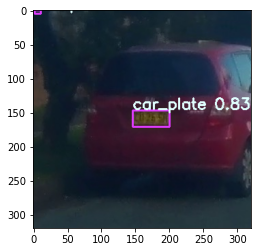

In [ ]:
#_ = make_inference_with_tflite(interpreter,'vlcsnap-2022-09-05-14h57m40s824.jpg')
outputs = make_inference_with_tflite(interpreter,'vlcsnap-2022-09-05-14h57m44s482.jpg')
#_ = make_inference_with_tflite(interpreter,'vlcsnap-2022-09-05-15h02m24s169.jpg')

### Inspects `outputs`

CPU times: user 172 ms, sys: 6.61 ms, total: 179 ms
Wall time: 93.7 ms


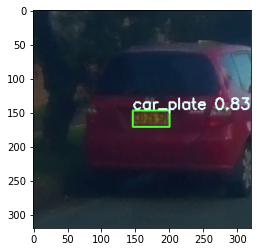

In [ ]:
%%time
outputs_onnx = make_inference_with_onnx(session,'vlcsnap-2022-09-05-14h57m44s482.jpg')

In [ ]:
outputs_onnx.shape

(1, 7)

CPU times: user 7.17 s, sys: 2.05 ms, total: 7.17 s
Wall time: 7.14 s


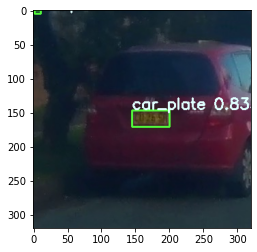

In [ ]:
%%time
outputs_tflite = make_inference_with_tflite(interpreter,'vlcsnap-2022-09-05-14h57m44s482.jpg')

In [ ]:
outputs_tflite.shape

(100, 7)

Why the shape is (100,7), is it because PyTorch was converted to ONXX with param `--topk-all 100`? We don't expect tflite to make 100 predictions for each example, most of which are identical.

The shape of output_onnx is correct.

In [ ]:
interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 496,
  'shape': array([100,   7], dtype=int32),
  'shape_signature': array([-1,  7], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

# Evaluations of PyTorch models

In [ ]:
import glob
import xml.etree.ElementTree as ET

In [ ]:
def preprocess_annotated_data(path):
  """Convert annotation xml files to yolo label text format,
  i.e., <object-class-id> <x_center> <y_center> <box_width> <box_height>
  """
  xml_list = []
  for xml_file in glob.glob(path + '/*.xml'):
    class_id,x,y,box_width,box_height = extract_xml(xml_file)

    # write back txt file
    example_name = xml_file[:-4]
    with open(f'{example_name}.txt','w') as fp:
      fp.write(f'{class_id}\t{x}\t{y}\t{box_width}\t{box_height}')

def extract_xml(xml_file):
  tree = ET.parse(xml_file)
  root = tree.getroot()
  for member in root.findall('object'):
    width = int(root.find('size')[0].text)
    height = int(root.find('size')[1].text)
    class_id = 0
    x_min = int(member[4][0].text)
    y_min = int(member[4][1].text)
    x_max = int(member[4][2].text)
    y_max = int(member[4][3].text)

    x = (x_min + x_max) / 2 / width
    y = (y_min + y_max) / 2 / height
    box_width = (x_max - x_min) / width
    box_height = (y_max - y_min) / height

  return class_id,x,y,box_width,box_height

In [ ]:
#test_raw was copied from CarPlateDetection/images/train
preprocess_annotated_data('dataset/test_raw')

In [ ]:
!rm dataset/test_raw.cache

rm: cannot remove 'dataset/test_raw.cache': No such file or directory


0	0.4765625	0.4625	0.190625	0.075


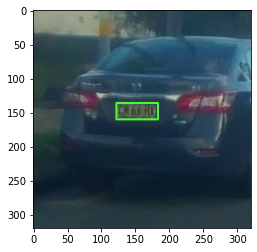

In [ ]:
# verify the box is derived correctly
with open('dataset/test_raw/vlcsnap-2022-09-05-14h57m40s824.txt') as fp:
#with open('dataset/train/a535ad108508872f.txt') as fp:
  label = fp.read()
  print(label)
  x,y,w,h = [float(i) for i in label.split()[1:]]
  #x0,y0,w,h = 2.3345714e+00, -1.7069006e-01,  1.4020466e+01, 6.5254388e+00

img, processed_img, ratio, dwdh = load_image('vlcsnap-2022-09-05-14h57m40s824.jpg','dataset/test_raw')
#img, processed_img, ratio, dwdh = load_image('a535ad108508872f.jpg','dataset/train')
x *= (416 - dwdh[0]/2)
y *= (416 - dwdh[1]/2)
w *= 416
h *= 416

box = np.array([x-w/2,y-h/2,x+w/2,y+h/2])
box -= np.array(dwdh*2)
box /= ratio
box = box.round().astype(np.int32).tolist()
color = COLORS['car_plate']
cv2.rectangle(img,box[:2],box[2:],color,2)
plt.imshow(img)

In [ ]:
!python models/yolov7/test.py --weights runs/train/exp/weights/best.pt --data dataset/data.xml --task val

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='dataset/data.xml', device='', exist_ok=False, img_size=640, iou_thres=0.65, name='exp', no_trace=False, project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='val', v5_metric=False, verbose=False, weights=['runs/train/exp/weights/best.pt'])
YOLOR 🚀 2022-10-2 torch 1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 200 layers, 6006646 parameters, 0 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
val: Scanning '/content/gdrive/My Drive/colab_notebooks/car_plate_detection_yolov

In [ ]:
!python models/yolov7/test.py --weights runs/train/exp/weights/best.pt --data dataset/data.xml --task test --img-size 320

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='dataset/data.xml', device='', exist_ok=False, img_size=320, iou_thres=0.65, name='exp', no_trace=False, project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='test', v5_metric=False, verbose=False, weights=['runs/train/exp/weights/best.pt'])
YOLOR 🚀 v0.1-113-g8035ee6 torch 1.12.1+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 200 layers, 6006646 parameters, 0 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
test: Scanning '/content/gdrive/My Drive/colab_notebooks/car_plate_detection_yolov7/d

## Spot checks

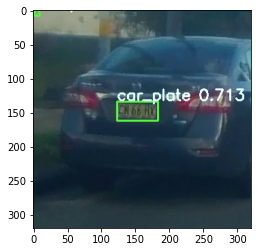

In [ ]:
_ = make_inference_with_tflite(interpreter,'vlcsnap-2022-09-05-14h57m40s824.jpg')

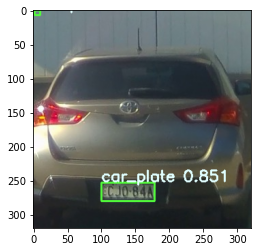

In [ ]:
_ = make_inference_with_tflite(interpreter,'vlcsnap-2022-09-05-15h02m24s169.jpg')

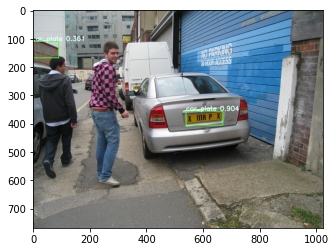

In [ ]:
_ = make_inference_with_tflite(interpreter,'Copy of 0a77fa2843b2f661.jpg')